<a href="https://colab.research.google.com/github/maritverboom/TM10007_PROJECT/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment Group 15
Bart Formsma: 4438450

Eline van Lange: 4390210

Laurien Reinders: 4472306

Marit Verboom: 4453778


In [36]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

## Importing packages

In [0]:
# General packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import seaborn as sns

# Feature selection methods
from sklearn import feature_selection
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from yellowbrick.regressor import AlphaSelection
from sklearn.feature_selection import SelectFromModel

# Classifiers
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Statistics
from statistics import mean
from statistics import stdev
from sklearn.metrics import confusion_matrix
from math import sqrt

## Function for learning curve in order te evaluate model

In [0]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Function to plot a StandardScaler.
    Input:
    - estimator: object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.
    - title: string, title of the figure
    - x: data_train
    - y: data_stage
    - axes: axes to use for plotting the curves
    - ylim: minimum and maximum yvalues plotted
    - cv: cross-validation generator
    - n_jobs: number of jobs to run in parallel
    - train_sizes: the test data that should be scaled
    Output:
    - Learning curve plot
    """
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  =  model_selection.learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

## Data Loading
- Loading the provided Head & Neck dataset
- Splitting the data in train- and testset
- Binarizing tumor stages: TM12 = 0, TM34 = 1


In [39]:
# Import dataset
from hn.load_data import load_data
data = load_data()
data_start = data
print(f'The number of samples (the patients): {len(data.index)}')
print(f'The number of columns (the features): {len(data.columns)}')

# Splitting the data in train- and testpart with a portion of 'test_size' testing data (20%)
data_train, data_test = model_selection.train_test_split(data, test_size=0.20, stratify=data['label'])

print(f'The number of samples of train data : {len(data_train.index)}')
print(f'The number of samples of test data : {len(data_test.index)}')

# dataframe containing tumor stadium of subject (T12/T34)
stage_train = data_train['label']             
stage_test = data_test['label'] 

# dataframe containing all feature columns except 'label' (tumor stadium of subject)
data_train = data_train.drop(columns='label') 
data_test = data_test.drop(columns='label')

# Binarize label data
stage_train = preprocessing.label_binarize(stage_train, ['T12', 'T34'])
stage_train = [i[0] for i in stage_train]
stage_test = preprocessing.label_binarize(stage_test, ['T12', 'T34'])
stage_test = [i[0] for i in stage_test]

labels_T12_train = stage_train.count(0)
labels_T12_test = stage_test.count(0)
labels_T34_train = stage_train.count(1)
labels_T34_test = stage_test.count(1)
print(f'Train samples with label T12: {labels_T12_train}/{len(data_train.index)}, Test samples with label T12: {labels_T12_test}/{len(data_test.index)}, total number of samples with label T12: {labels_T12_train + labels_T12_test}/{len(data.index)}')
print(f'Train samples with label T34: {labels_T34_train}/{len(data_train.index)}, Test samples with label T34: {labels_T34_test}/{len(data_test.index)}, total number of samples with label T34: {labels_T34_train + labels_T34_test}/{len(data.index)}')


The number of samples (the patients): 113
The number of columns (the features): 160
The number of samples of train data : 90
The number of samples of test data : 23
Train samples with label T12: 46/90, Test samples with label T12: 12/23, total number of samples with label T12: 58/113
Train samples with label T34: 44/90, Test samples with label T34: 11/23, total number of samples with label T34: 55/113


## Data cleaning
- Removing columns where > 25% of the values are 0.0
- Removing columns containing the same value for each sample


In [40]:
# Function for data cleaning
def data_cleaning(data_train, data_test):
    """
    Function for cleaning the data, by removing columns where >25% of the values are 0.0
    and removing columns containing the same value for each sample.
    Input:
    - data_train: the train data that should be cleaned
    - data_test: the test data that should be cleaned
    Output:
    - data_train: the cleaned train data
    - data-test: the cleaned test data
    """
    # Remove all columns where more than 25% of the values are 0.0
    drop_cols_train = data_train.columns[(data_train == 0).sum() > 0.25*data_train.shape[1]]
    drop_cols_test = data_test.columns[(data_train ==0).sum() > 0.25*data_train.shape[1]]
    data_train.drop(drop_cols_train, axis = 1, inplace = True) 
    data_test.drop(drop_cols_test, axis = 1, inplace = True)
    
    # Remove all columns with no std
    drop_std_train = data_train.columns[data_train.std() == 0]
    drop_std_test = data_test.columns[data_train.std() == 0]
    data_train.drop(drop_std_train, axis = 1, inplace = True) 
    data_test.drop(drop_std_test, axis = 1, inplace = True)
    
    return data_train, data_test

# Apply data_cleaning to data_train and data_test in order to evaluate different scalers, feature selection methods and classifiers.
data_train, data_test = data_cleaning(data_train, data_test)

print(f'TRAIN: The number of columns after cleaning: {len(data_train.columns)}, and the number of rows: {len(data_train.index)}')
print(f'TEST: The number of columns after cleaning: {len(data_test.columns)},  and the number of rows: {len(data_test.index)}')


TRAIN: The number of columns after cleaning: 149, and the number of rows: 90
TEST: The number of columns after cleaning: 149,  and the number of rows: 23


## Data standard scaling

- Scaling the train- and test dataset with a Standard Scaler
- Scaling the train- and test dataset with a Robust Scaler
- Scaling the train- and test dataset with a MinMax scaler
 

Scaling the train- and test dataset with a Standard Scaler

In [0]:
def data_scaling(data_train, data_test):
    """
    Function to scale the data using a StandardScaler.
    Input:
    - data_train: the train data that should be scaled
    - data_test: the test data that should be scaled
    Output:
    - data_train_scaled: the standard scaled data
    - data-test_scaled: the standard scaled data 
    """
    # Scale the data (train on train set)
    scaler = preprocessing.StandardScaler()   
    scaler.fit(data_train)  

    # Perform scaling on both train and testset, returing scaled dataframe
    data_train_scaled = pd.DataFrame(scaler.transform(data_train), columns = data_train.columns)
    data_test_scaled = pd.DataFrame(scaler.transform(data_test), columns=data_test.columns) 

    return data_train_scaled, data_test_scaled

# Apply data_scaling to data_train and data_test in order to evaluate different scalers, feature selection methods and classifiers.
data_train_scaled, data_test_scaled = data_scaling(data_train, data_test)


Scaling the train- and test dataset with a Robust Scaler

In [0]:
def data_scaling_robust(data_train, data_test):
    """
    Function to scale the data using a RobustScaler.
    Input:
    - data_train: the train data that should be scaled
    - data_test: the test data that should be scaled
    Output:
    - data_train_scaled_robust: the robust scaled data
    - data-test_scaled_robust: the robust scaled data
    """
    # Scale the data (train on train set)
    scaler = preprocessing.RobustScaler()   
    scaler.fit(data_train)  

    # Perform scaling on both train and testset, returing scaled dataframe
    data_train_scaled_robust = pd.DataFrame(scaler.transform(data_train), columns = data_train.columns)
    data_test_scaled_robust = pd.DataFrame(scaler.transform(data_test), columns=data_test.columns) 

    return data_train_scaled_robust, data_test_scaled_robust

# Apply data_scaling_robust to data_train and data_test in order to evaluate different scalers, feature selection methods and classifiers.
data_train_scaled_robust, data_test_scaled_robust = data_scaling_robust(data_train, data_test)

Scaling the train- and test dataset with a MinMax Scaler

In [0]:
def data_scaling_MinMax(data_train, data_test):
    """
    Function to scale the data using a MinMax Scaler.
    Input:
    - data_train: the train data that should be scaled
    - data_test: the test data that should be scaled
    Output:
    - data_train_scaled_minmax: the standard scaled data
    - data-test_scaled_minmax: the standard scaled data
    """
    # Scale the data (train on train set)
    scaler = preprocessing.MinMaxScaler()   
    scaler.fit(data_train)  

    # Perform scaling on both train and testset, returing scaled dataframe
    data_train_scaled_minmax = pd.DataFrame(scaler.transform(data_train), columns = data_train.columns)
    data_test_scaled_minmax = pd.DataFrame(scaler.transform(data_test), columns=data_test.columns) 

    return data_train_scaled_minmax, data_test_scaled_minmax

# Apply data_scaling_MinMax to data_train and data_test in order to evaluate different scalers, feature selection methods and classifiers.
data_train_scaled_minmax, data_test_scaled_minmax = data_scaling_MinMax(data_train, data_test)

## Feature selection, elimination and transformation

- Recursive Feature Elimination
- Univariate Feature Selection
- Principal Component Analysis
- L1/Lasso Regression Feature Selection

Recursive Feature Elimination (rfecv)


-   Evaluation of stability of rfecv




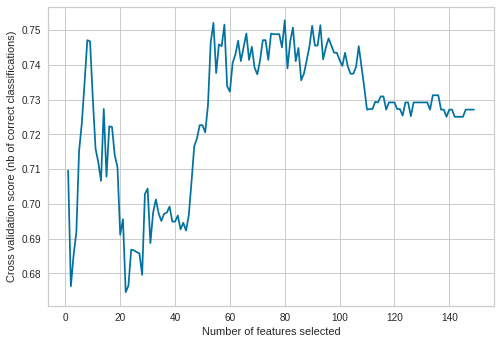

Num Features: 80
Numbers of features selected each run: [92, 1, 4, 2, 1, 36, 26, 12, 1, 86]

Conclusion: the number of features selected after each run differs such much, that the RFECV as method for feature elimination is unstable


In [44]:
# Create the RFE object
svc = svm.SVC(kernel="linear")  

# classifications
rfecv = feature_selection.RFECV(
    estimator=svc, step=1, 
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
fit_rfecv = rfecv.fit(data_train_scaled, stage_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print("Num Features: %d" % fit_rfecv.n_features_)

data_train_rfecv = rfecv.transform(data_train_scaled)
data_test_rfecv = rfecv.transform(data_test_scaled)

# Evaluating stability RFECV by running it 5 times using a different train-test split
number_features_selected = []
for _ in range(10):
    # Splitting the data in train- and testpart with a portion of 'test_size' testing data (20%)
    data_train, data_test = model_selection.train_test_split(data, test_size=0.20, stratify=data['label'])

    stage_train = data_train['label']             
    stage_test = data_test['label'] 

    data_train = data_train.drop(columns='label') 
    data_test = data_test.drop(columns='label')

    stage_train = preprocessing.label_binarize(stage_train, ['T12', 'T34'])
    stage_train = [i[0] for i in stage_train]
    stage_test = preprocessing.label_binarize(stage_test, ['T12', 'T34'])
    stage_test = [i[0] for i in stage_test]

    data_train, data_test = data_cleaning(data_train, data_test)
    data_train, data_tst = data_scaling(data_train, data_test)

    fit_rfecv = rfecv.fit(data_train_scaled, stage_train)

    number_features_selected.append(fit_rfecv.n_features_)
print(f'Numbers of features selected each run: {number_features_selected}')

print(f'\nConclusion: the number of features selected after each run differs such much, that the RFECV as method for feature elimination is unstable')



Feature selection using univariate feature selection
- Function to perform univariate feature selection on data
- Evaluation of stability of univariate feature selection
- Learning curve to determine which percentage for univariate feature selection should be taken

                                         Specs      Score
39                         tf_GLRLM_RunEntropy  37.911944
42                      tf_GLRLM_RunPercentage  29.731052
40             tf_GLRLM_RunLengthNonUniformity  27.233007
25                          sf_rad_dist_avg_2D  26.809746
0                                    hf_energy  24.954107
32             tf_GLRLM_GrayLevelNonUniformity  24.694820
41   tf_GLRLM_RunLengthNonUniformityNormalized  24.389168
134                     tf_LBP_kurtosis_R3_P12  21.854533
43                        tf_GLRLM_RunVariance  21.841381
125                      tf_Gabor_0.5A1.57skew  17.338733
26                          sf_rad_dist_std_2D  16.944335
121                      tf_Gabor_0.5A1.57kurt  16.232761
35                    tf_GLRLM_LongRunEmphasis  15.989225
37        tf_GLRLM_LongRunLowGrayLevelEmphasis  15.587326
28                         sf_roughness_std_2D  15.090368
131                      tf_Gabor_0.5A2.36skew  14.980200
44            

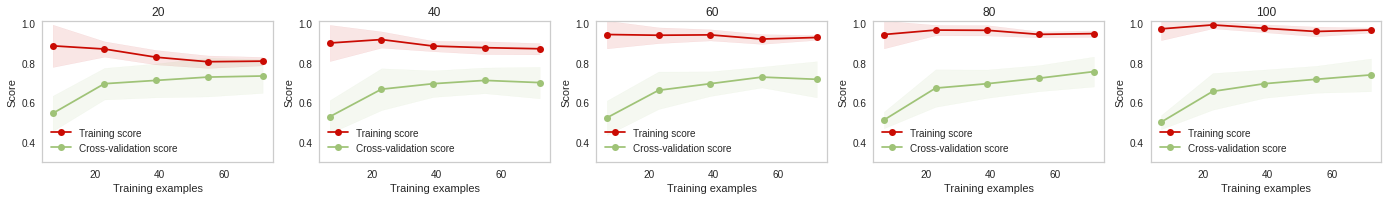

In [45]:
# Function to apply univariate feature selection to data_train and data_test
def uni(data_train, data_test, stage_train, percentile):
    """
    Function to perform univariate feature selection 
    input:
    - data_train: train data that should be transformed by univariate feature selection, which will be trained on this train data
    - data-test: test data that should be transformed by univariate feature selection
    - percentile: the percentage of the best predicting features that should be used
    output:
    - data_train_uni: transformed train dataset by univariate feature selection trained on train data
    - data_test_uni: transformed test dataset by univariate feature selection trained on train data
    """
    # Train univariate feature selection on train data
    selector_uni = SelectPercentile(f_classif, percentile)
    selector_uni.fit(data_train, stage_train)

    # Transform data using univariate feature selection
    data_train_uni = selector_uni.transform(data_train)
    data_test_uni = selector_uni.transform(data_test)
    
    # Return transformed data
    return data_train_uni, data_test_uni

# Apply univariate feature selection function to data_train and data_test in order to evaluate different feature selection methods and classifiers.
data_train_uni, data_test_uni = uni(data_train, data_test, stage_train, 20)

# Evaluation univariate feature selection as feature selection method on dataset
selector_uni = SelectPercentile(f_classif, 20)
selector_uni.fit(data_train, stage_train)
dfscores = pd.DataFrame(selector_uni.scores_)
dfcolumns = pd.DataFrame(data_train.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] 
print(featureScores.nlargest(int(0.2*len(featureScores)),'Score'))  #print 40 best features

print('\nConclusion: running the univariate feature selection method for different train-test splits results in around the same top features selected, thus this method is stable and will be further processed and trained.')

# Evaluating what percentage of features needs to be selected, using a learning curve
perc = [20, 40, 60, 80, 100] # the evaluated percentages
svm_scaler = svm.SVC() # evaluating is done using a svm classifier
svm_scaler.fit(data_train_uni, stage_train)
fig = plt.figure(figsize=(24,15))
num = 0   
cvlc = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

for per in perc:
    data_train_uni, stage_train_uni  = uni(data_train, data_test, stage_train, per)
    title = str(per)
    ax = fig.add_subplot(5, 5, num + 1)
    plot_learning_curve(svm_scaler, title, data_train_uni, stage_train, ax, ylim=(0.3, 1.01), cv=cvlc)
    num += 1
print(f'\nConclusion: the chosen percentage of best predicting features using univariate feature selection is 20%, since otherwise the model is more prone to overfitting according to the learning curve')

print(f'\nLearning curve univariate feature selection and SVM classifier:')

Principal Component Analysis (PCA)
- Function to perform PCA on data
- Evaluation of stability of PCA (using a standard scaler for preprocessing the data)

In [46]:
# Function to apply PCA to data_train and data_test
def pca_opt(data_train, data_test):
    """
    Function to perform PCA
    input:
    - data_train: train data that should be transformed by PCA, which will be trained on this train data
    - data-test: test data that should be transformed by PCA
    output:
    - data_train: transformed train dataset by PCA trained on train data
    - data_test: transformed test dataset by PCA trained on train data
    """
    pca=PCA().fit(data_train)

    # Amount of n-components based on a variance level of 0.99
    var = np.cumsum(pca.explained_variance_ratio_)
    n_comp = np.where(var>0.99)[0][0]
    pca_train = PCA(n_components=n_comp)
    pca_train.fit(data_train)

    # Transform data using PCA
    data_train = pca_train.transform(data_train)
    data_test = pca_train.transform(data_test)

    # Return transformed train- and testdata
    return data_train, data_test

# Apply PCA function to data_train and data_test in order to evaluate different feature selection methods and classifiers.
data_train_pca, data_test_pca = pca_opt(data_train_scaled, data_test_scaled)

# Evaluation stability of PCA as feature selection method on dataset
number_of_components = []
for _ in range(10):
    # Splitting the data in train- and testpart with a portion of 'test_size' testing data (20%)
    data_train, data_test = model_selection.train_test_split(data, test_size=0.20, stratify=data['label'])

    stage_train = data_train['label']             
    stage_test = data_test['label'] 

    data_train = data_train.drop(columns='label') 
    data_test = data_test.drop(columns='label')

    stage_train = preprocessing.label_binarize(stage_train, ['T12', 'T34'])
    stage_train = [i[0] for i in stage_train]
    stage_test = preprocessing.label_binarize(stage_test, ['T12', 'T34'])
    stage_test = [i[0] for i in stage_test]

    data_train, data_test = data_cleaning(data_train, data_test)
    data_train_scaled_standard, data_test_scaled_standard = data_scaling(data_train, data_test)
    data_train_pca_standard, data_test_pca_standard = pca_opt(data_train_scaled_standard, data_test_scaled_standard)
    number_of_components.append(data_train_pca_standard.shape[1])

print(f'Numbers of components selected each run: {number_of_components}')

print(f'\nConclusion: the number of components selected after each run is 55 or 56, which means the PCA is stable on our data and will be further processed and trained.')


Numbers of components selected each run: [56, 56, 56, 55, 55, 56, 55, 56, 55, 55]

Conclusion: the number of components selected after each run is 55 or 56, which means the PCA is stable on our data and will be further processed and trained.


Lasso feature selection
- Function to perform lasso feature selection
- Evaluation of stability of the alpha parameter in lasso feature selection

Chosen value as best alpha each run: [0.0566586642518465, 0.06771007055376069, 0.0575839573357165, 0.04516207309716852, 0.0566586642518465, 0.04301979551243629, 0.10317342294361626, 0.0575839573357165, 0.060451493537854416, 0.039035278878871385]
The mean value for the best alpha is: 0.05870373776988336 with standard deviation 0.017915868353407922

Number of features selected each: [12, 12, 12, 17, 14, 17, 4, 14, 9, 17]
The mean number of features selected is: 12.8 with standard deviation 4.077035960378842

Conclusion: the chosen value as best alpha and the number of features selected selected each run are different each run with for both standard deviations that were relatively high according to our opinion, which means the lasso feature selection method is unstable on our data and will therefore not be further processed and trained.


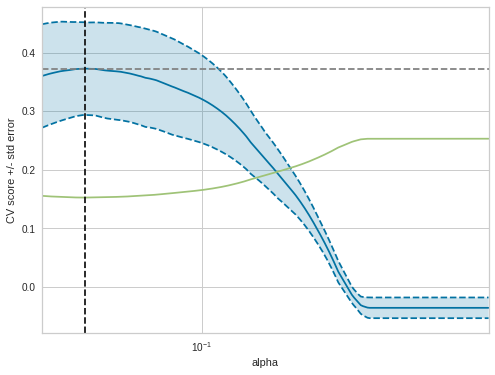

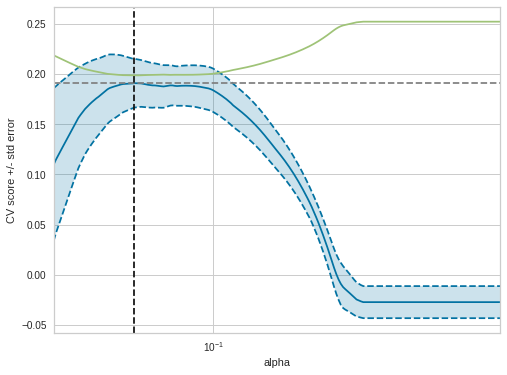

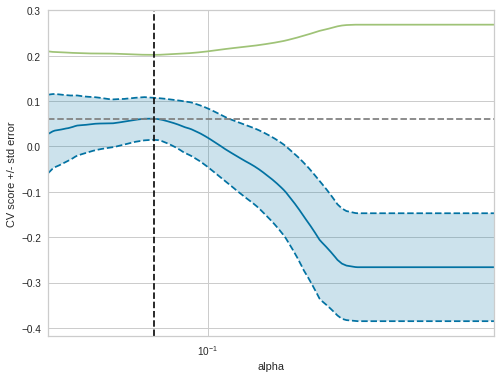

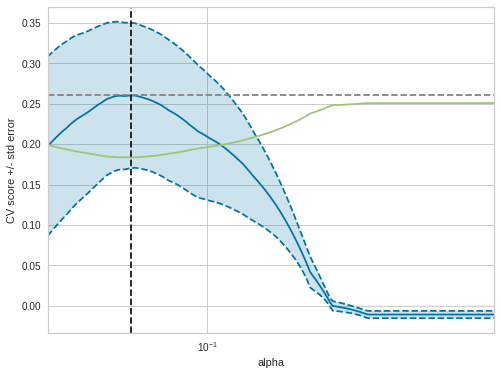

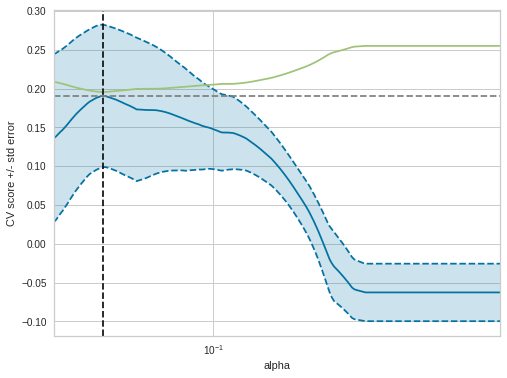

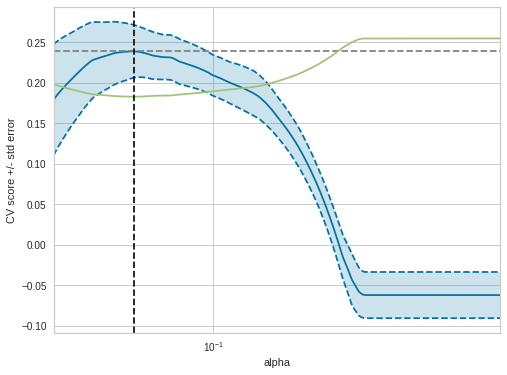

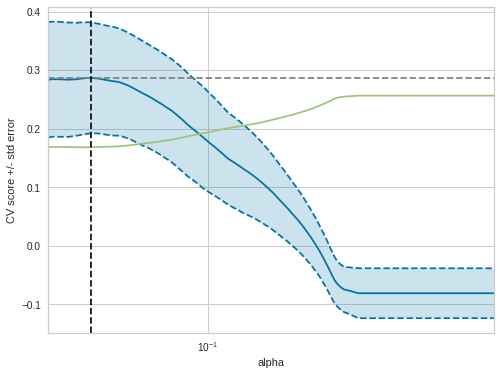

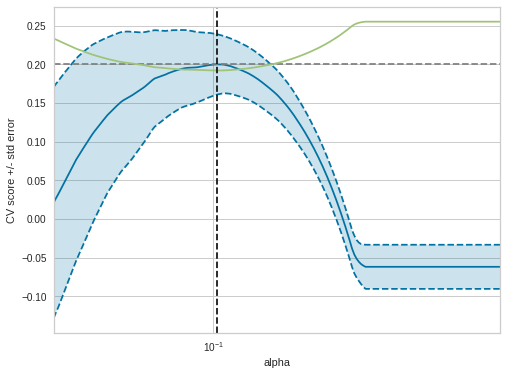

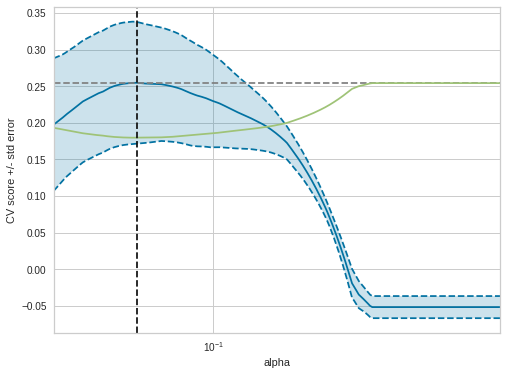

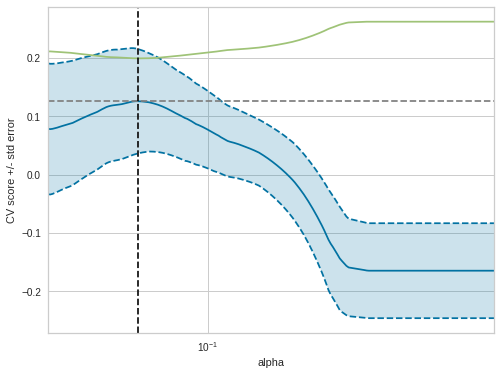

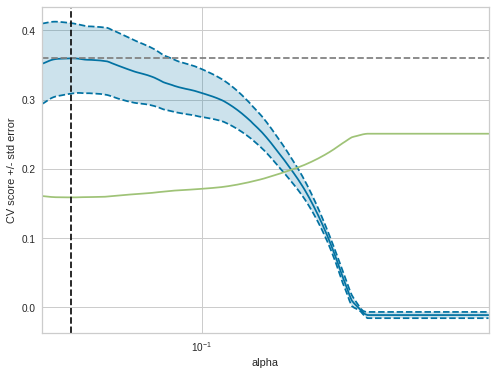

In [49]:
# Function to apply lasso feature selection to data_train and data_test
def lasso_func(n_alphas, lasso, data_train, stage_train, data_test):
    """
    Function to perform L1 feature selection
    input:
    - n_alphas: the number of alphas which will be evaluated for optimization of the alpha
    - lasso: linear model tained with L1 prior as regularizer: the lasso
    - data_train: train data that should be transformed by PCA, which will be trained on this train data
    - stage_train: the labels of the train data
    - data-test: test data that should be transformed by PCA
    output:
    - data_train_l1: transformed train dataset by PCA trained on train data
    - data_test_l1: transformed test dataset by PCA trained on train data
    - n_selected: the number of features selected after applying the lasso feature selection method
    - alpha_best: the best alpha selected by hyperparameter optimization
    - plt: a plot showing the alphas and scores
    """
    # Determine optimal alpha
    alphas = np.logspace(-1.5, -0.1, n_alphas)
    hyperparameters_l1 = [{'alpha': alphas}]
    n_folds = 5
    clf = GridSearchCV(lasso, hyperparameters_l1, cv=n_folds, refit=False)
    clf.fit(data_train, stage_train)

    # Scores
    scores = clf.cv_results_['mean_test_score']
    scores_std = clf.cv_results_['std_test_score']

    # Plot
    plt.figure().set_size_inches(8, 6)
    plt.semilogx(alphas, scores)
    # plot error lines showing +/- std. errors of the scores
    std_error = scores_std / np.sqrt(n_folds)
    plt.semilogx(alphas, scores + std_error, 'b--')
    plt.semilogx(alphas, scores - std_error, 'b--')
    plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
    plt.ylabel('CV score +/- std error')
    plt.xlabel('alpha')
    plt.axhline(np.max(scores), linestyle='--', color='.5')
    plt.xlim([alphas[0], alphas[-1]])
    
    # Instantiate the linear model and visualizer
    model_l1 = LassoCV(alphas = alphas)
    visualizer = AlphaSelection(model_l1)
    visualizer.fit(data_train, stage_train)
    alpha_best = model_l1.alpha_

    # Training Lasso on train data
    selector_l1 = SelectFromModel(estimator=Lasso(alpha=alpha_best, random_state = 42))
    selector_l1.fit(data_train, stage_train)

    # Transform data_train and data_set by applying the selector
    data_train_l1 = selector_l1.transform(data_train)
    data_test_l1 = selector_l1.transform(data_test)
    n_selected = data_train_l1.shape[1]
    
    # Return transformed data_train and data_test and a plot
    return data_train_l1, data_test_l1, n_selected, alpha_best, plt

# Apply lasso feature selection function to data_train and data_test in order to evaluate different feature selection methods and classifiers.
lasso = Lasso(max_iter=10000)
n_alphas = 200
data_train_l1, data_test_l1, n_selected, alpha_best, plt = lasso_func(n_alphas, lasso, data_train_scaled, stage_train, data_test)
n_original = data_train_scaled.shape[1]

# Evaluation of the stability of the alpha of lasso as feature selection method on dataset
chosen_as_best_alpha = []
selected_number_of_features = []
for _ in range(10):
    
    # Splitting the data in train- and testpart with a portion of 'test_size' testing data (20%)
    data_train, data_test = model_selection.train_test_split(data, test_size=0.20, stratify=data['label'])

    stage_train = data_train['label']             
    stage_test = data_test['label'] 

    data_train = data_train.drop(columns='label') 
    data_test = data_test.drop(columns='label')

    stage_train = preprocessing.label_binarize(stage_train, ['T12', 'T34'])
    stage_train = [i[0] for i in stage_train]
    stage_test = preprocessing.label_binarize(stage_test, ['T12', 'T34'])
    stage_test = [i[0] for i in stage_test]

    data_train, data_test = data_cleaning(data_train, data_test)
    data_train_scaled_standard, data_test_scaled_standard = data_scaling(data_train, data_test)
    
    data_train_l1, data_test_l1, n_selected, alpha_best, plt = lasso_func(n_alphas, lasso, data_train_scaled_standard, stage_train, data_test_scaled_standard)
    chosen_as_best_alpha.append(alpha_best)
    selected_number_of_features.append(n_selected)

print(f'Chosen value as best alpha each run: {chosen_as_best_alpha}')
print(f'The mean value for the best alpha is: {mean(chosen_as_best_alpha)} with standard deviation {stdev(chosen_as_best_alpha)}')

print(f'\nNumber of features selected each: {selected_number_of_features}')
print(f'The mean number of features selected is: {mean(selected_number_of_features)} with standard deviation {stdev(selected_number_of_features)}')

print(f'\nConclusion: the chosen value as best alpha and the number of features selected selected each run are different each run with for both standard deviations that were relatively high according to our opinion, which means the lasso feature selection method is unstable on our data and will therefore not be further processed and trained.')

## Selecting the best scaler based on stability on selecting components of PCA


In [54]:
data_train_pca_standard_components = []
data_train_pca_robust_components = []
data_train_pca_minmax_components = []

for _ in range(100):
    # Splitting the data in train- and testpart with a portion of 'test_size' testing data (20%)
    data_train, data_test = model_selection.train_test_split(data, test_size=0.20, stratify=data['label'])

    stage_train = data_train['label']             
    stage_test = data_test['label'] 

    data_train = data_train.drop(columns='label') 
    data_test = data_test.drop(columns='label')

    stage_train = preprocessing.label_binarize(stage_train, ['T12', 'T34'])
    stage_train = [i[0] for i in stage_train]
    stage_test = preprocessing.label_binarize(stage_test, ['T12', 'T34'])
    stage_test = [i[0] for i in stage_test]

    data_train, data_test = data_cleaning(data_train, data_test)

    # Selection of the scaler by comparing the mean componentens selected in PCA and its standard deviation
    data_train_scaled_standard, data_test_scaled_standard = data_scaling(data_train, data_test)
    data_train_scaled_robust, data_test_scaled_robust = data_scaling_robust(data_train, data_test)
    data_train_scaled_minmax, data_test_scaled_minmax = data_scaling_MinMax(data_train, data_test)

    data_train_pca_standard, data_test_pca_standard = pca_opt(data_train_scaled_standard, data_test_scaled_standard)
    data_train_pca_standard_components.append(data_train_pca_standard.shape[1])
    data_train_pca_robust, data_test_pca_robust = pca_opt(data_train_scaled_robust, data_test_scaled_robust)
    data_train_pca_robust_components.append(data_train_pca_robust.shape[1])
    data_train_pca_minmax, data_test_pca_minmax = pca_opt(data_train_scaled_minmax, data_test_scaled_minmax)
    data_train_pca_minmax_components.append(data_train_pca_minmax.shape[1])

print(data_train_pca_standard_components)
data_train_pca_standard_mean_components = mean(data_train_pca_standard_components)
data_train_pca_standard_stdev_components = stdev(data_train_pca_standard_components)
data_train_pca_robust_mean_components = mean(data_train_pca_robust_components)
data_train_pca_robust_stdev_components = stdev(data_train_pca_robust_components)
data_train_pca_minmax_mean_components = mean(data_train_pca_minmax_components)
data_train_pca_minmax_stdev_components = stdev(data_train_pca_minmax_components)

print(f'The mean of the components in PCA selected using standard scalar is: {data_train_pca_standard_mean_components} with standard deviation: {data_train_pca_standard_stdev_components}')
print(f'The mean of the components in PCA selected using robust scalar is: {data_train_pca_robust_mean_components} with standard deviation: {data_train_pca_robust_stdev_components}')
print(f'The mean of the components in PCA selected using MinMax scalar is: {data_train_pca_minmax_mean_components} with standard deviation: {data_train_pca_minmax_stdev_components}')

print(f'\nConclusion: no major differences between the standard deviation for standard and MinMax scaler, but standard scaler is slightly better, so used as scaler from now on.')



[55, 55, 55, 55, 56, 55, 56, 55, 56, 56, 55, 55, 56, 55, 55, 55, 55, 56, 55, 56, 56, 56, 57, 55, 55, 55, 55, 55, 56, 56, 56, 55, 55, 56, 55, 56, 56, 55, 56, 55, 54, 55, 56, 55, 55, 55, 55, 55, 55, 55, 56, 56, 55, 55, 55, 56, 56, 55, 55, 55, 56, 57, 56, 56, 56, 56, 55, 54, 55, 56, 55, 55, 56, 56, 56, 55, 55, 55, 56, 55, 55, 56, 56, 55, 54, 55, 55, 55, 56, 54, 55, 56, 56, 56, 55, 55, 56, 55, 55, 55]
The mean of the components in PCA selected using standard scalar is: 55.38 with standard deviation: 0.5993262210114948
The mean of the components in PCA selected using robust scalar is: 43.08 with standard deviation: 4.787779055347927
The mean of the components in PCA selected using MinMax scalar is: 52.47 with standard deviation: 0.6105966613307698

Conclusion: no major differences between the standard deviation for standard and MinMax scaler, but standard scaler is slightly better, so used as scaler from now on.


## Classifier functions, including optimization
- k-nearest neighbors (k-NN)
- Support Vector Machine (SVM)
- Random Forest (RF)
- Neural Network (NN)

k-NN

In [0]:
def knn_class(data_train, data_test, stage_train, stage_test):
    """
    Function for performing the k-NN classifier
    and optimization of the k-NN algorithm hyperparameters:
      - n_neighbours
      - leaf_size
    input:
      - data_train: data used to train k-NN classifier and perform classifier on
      - data_test: data set of which labels will be predicted using the k-NN algorithm
      - stage_train: true labels of train data set
      - stage_test: true labels of test data set
    Output is:
      - knn: a classifier with optimized hyperparameters trained on the train data set
      - acc_train: the accuracy of the optimized classifier on the trainig data
      - acc_test: the accuracy of the optimized classifier on the testing data
      - auc_test: the area under the curve of the optimized classifier on the testing data
      - sens: the sensitivity of the optimized classifier on the testing data
      - spec: the specificity of the optimized classifier on the testing data
    """

    # Hyperparameters optimization 
    n_n = list(range(1,30))
    # weights = ['uniform', 'distance']
    leaf_size = list(range(1,50))
    # p=[1,2]
    hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_n)
    knn_tune = neighbors.KNeighborsClassifier()
    clf_tune_knn = model_selection.RandomizedSearchCV(knn_tune, hyperparameters, n_iter = 30, cv=5)
    best_model = clf_tune_knn.fit(data_train, stage_train)
    n_n_best = best_model.best_estimator_.get_params()['n_neighbors']
    # weights_best = best_model.best_estimator_.get_params()['weights']
    leaf_size_best = best_model.best_estimator_.get_params()['leaf_size']
    # p_best = best_model.best_estimator_.get_params()['p']
    
    # Trainnig classifier on train data
    knn = neighbors.KNeighborsClassifier(leaf_size=leaf_size_best, n_neighbors=n_n_best)
    knn.fit(data_train, stage_train)

    # Predicting labels of train and test data using the trained classifier
    label_train_knn = knn.predict(data_train)
    label_test_knn = knn.predict(data_test)
    
    # Performance
    acc_train = knn.score(data_train, stage_train)
    acc_test = knn.score(data_test, stage_test)
    # Calculating confusion matrix
    cm = metrics.confusion_matrix(stage_test, label_test_knn)
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    sens = (TP / float(TP+FN))
    spec = (TN / float(TN + FP))
    
    # Try - except to prevent error during running with small test sizes
    try:
        auc_test = metrics.roc_auc_score(label_test_knn, stage_test)
    except ValueError:
        auc_test = float("NaN")

    # Return optimised classifier, accuracy calculated on the train set, accuracy calculated on the test set, auc calculated on the test set, sensitivity calculated on the test set, specificity calculated on the test set 
    return knn, acc_train, acc_test, auc_test, sens, spec

SVM 

In [0]:
def svm_class(data_train, data_test, stage_train, stage_test):
    """
    Function for performing the SVM classifier
    and optimization of the SVM algorithm hyperparameters:
      - kernel
      - C
      - degree
    input:
      - data_train: data used to train SVM classifier and perform classifier on
      - data_test: data set of which labels will be predicted using the SVM algorithm
      - stage_train: true labels of train data set
      - stage_test: true labels of test data set
    Output is:
      - svc: a classifier with optimized hyperparameters trained on the train data set
      - acc_train: the accuracy of the optimized classifier on the trainig data
      - acc_test: the accuracy of the optimized classifier on the testing data
      - auc_test: the area under the curve of the optimized classifier on the testing data
      - sens: the sensitivity of the optimized classifier on the testing data
      - spec: the specificity of the optimized classifier on the testing data
     """
    # Hyperparameter optimization
    kernels = ['linear', 'poly', 'rbf']
    # gammas = [0.1, 1, 10, 100]
    cs = [0.1, 1, 10, 100, 1000]
    degrees = [0, 1, 2, 3, 4, 5, 6] # use only for 'poly'
    hyperparameters = dict(kernel = kernels, C = cs, degree = degrees)
    svm_tune = svm.SVC()
    clf_tune_svm = model_selection.RandomizedSearchCV(svm_tune, hyperparameters, n_iter = 30, cv = 5)
    best_model_svm = clf_tune_svm.fit(data_train,stage_train)
    kernel_best = best_model_svm.best_estimator_.get_params()['kernel']
    # gamma_best  = best_model_svm.best_estimator_.get_params()['gamma']
    C_best = best_model_svm.best_estimator_.get_params()['C']
    degree_best = best_model_svm.best_estimator_.get_params()['degree']
    
    # Trainnig classifier on train data
    svc = svm.SVC(C=C_best, kernel=kernel_best, degree=degree_best)
    svc.fit(data_train, stage_train)

    # Predicting labels of train and test data using the trained classifier
    label_train_svm = svc.predict(data_train)
    label_test_svm= svc.predict(data_test)
    
    # Performance
    acc_train = svc.score(data_train, stage_train)
    acc_test = svc.score(data_test, stage_test)
    # Calculating confusion matrix
    cm = metrics.confusion_matrix(stage_test, label_test_svm)
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    sens = (TP / float(TP+FN))
    spec = (TN / float(TN + FP))
    
    # Try - except to prevent error during running with small test sizes
    try:
        auc_test = metrics.roc_auc_score(label_test_svm, stage_test)
    except ValueError:
        auc_test = float("NaN")
    
    # Return optimised classifier, accuracy calculated on the train set, accuracy calculated on the test set, auc calculated on the test set, sensitivity calculated on the test set, specificity calculated on the test set 
    return svc, acc_train, acc_test, auc_test, sens, spec

RF

In [0]:
def rf_class(data_train, data_test, stage_train, stage_test):
    """
    Function for performing the RF classifier
    and optimization of the RF algorithm hyperparameters:
      - n_estimators
      - min_sample_split
      - min_samples_leaf
    input:
      - data_train: data used to train RF classifier and perform classifier on
      - data_test: data set of which labels will be predicted using the RF algorithm
      - stage_train: true labels of train data set
      - stage_test: true labels of test data set
    Output is:
      - rfc: a classifier with optimized hyperparameters trained on the train data set
      - acc_train: the accuracy of the optimized classifier on the trainig data
      - acc_test: the accuracy of the optimized classifier on the testing data
      - auc_test: the area under the curve of the optimized classifier on the testing data
      - sens: the sensitivity of the optimized classifier on the testing data
      - spec: the specificity of the optimized classifier on the testing data
    """

    # Hyperparameters optimization 
    n_estimators = [10, 30, 50, 100, 300]                  
    min_samples_split = [2, 7, 10, 12, 20]      
    min_samples_leaf = [3, 5, 10, 15, 20]             
    hyperparameters_rfc = dict(n_estimators=n_estimators, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf)
    rfc_tune = RandomForestClassifier()
    clf_tune_rfc = model_selection.RandomizedSearchCV(rfc_tune, hyperparameters_rfc, n_iter = 30, cv=5)
    best_model = clf_tune_rfc.fit(data_train, stage_train)
    n_estimators_best = best_model.best_estimator_.get_params()['n_estimators']
    min_samples_split_best = best_model.best_estimator_.get_params()['min_samples_split']
    min_samples_leaf_best = best_model.best_estimator_.get_params()['min_samples_leaf']

    # Trainnig classifier on train data
    rfc = RandomForestClassifier(n_estimators=n_estimators_best, min_samples_split = min_samples_split_best, min_samples_leaf = min_samples_leaf_best)
    rfc.fit(data_train, stage_train)
    
    # Predicting labels of train and test data using the trained classifier
    label_train_rfc = rfc.predict(data_train)
    label_test_rfc = rfc.predict(data_test)
    
    # Performance
    acc_train = rfc.score(data_train, stage_train)
    acc_test = rfc.score(data_test, stage_test)
    # Calculating confusion matrix
    cm = metrics.confusion_matrix(stage_test, label_test_rfc)
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    sens = (TP / float(TP+FN))
    spec = (TN / float(TN + FP))
    
    # Try - except to prevent error during running with small test sizes
    try:
        auc_test = metrics.roc_auc_score(label_test_rfc, stage_test)
    except ValueError:
        auc_test = float("NaN")
    
    # Return optimised classifier, accuracy calculated on the train set, accuracy calculated on the test set, auc calculated on the test set, sensitivity calculated on the test set, specificity calculated on the test set 
    return rfc, acc_train, acc_test, auc_test, sens, spec

NN

In [19]:
def nn_class(data_train, data_test, stage_train, stage_test):
    """
    Function for performing the NN classifier
    and optimization of the NN algorithm hyperparameters:
      - activation
      - solver
    input:
      - data_train: data used to train NN classifier and perform classifier on
      - data_test: data set of which labels will be predicted using the NN algorithm
      - stage_train: true labels of train data set
      - stage_test: true labels of test data set
    Output is:
      - nn: a classifier with optimized hyperparameters trained on the train data set
      - acc_train: the accuracy of the optimized classifier on the trainig data
      - acc_test: the accuracy of the optimized classifier on the testing data
      - auc_test: the area under the curve of the optimized classifier on the testing data
      - sens: the sensitivity of the optimized classifier on the testing data
      - spec: the specificity of the optimized classifier on the testing data
    """

    # Hyperparameters optimization 
    # hidden_layer_sizes = [(50,50,50), (50,100,50), (100,)]
    # batch_size = [5, 10, 15, 20, 25]                 
    activation = ['tanh', 'relu','identity', 'logistic'] 
    solver = ['lbfgs', 'sgd', 'adam']           
    hyperparameters_nn = dict(solver = solver, activation = activation)
    nn_tune = MLPClassifier()
    clf_tune_nn = model_selection.RandomizedSearchCV(nn_tune, hyperparameters_nn, n_iter = 15, cv=5)
    best_model = clf_tune_nn.fit(data_train, stage_train)
    # hidden_layer_sizes_best = best_model.best_estimator_.get_params()['hidden_layer_sizes']
    # batch_size_best = best_model.best_estimator_.get_params()['batch_size']
    activation_best = best_model.best_estimator_.get_params()['activation']
    solver_best = best_model.best_estimator_.get_params()['solver']
    
    # Trainnig classifier on train data
    nn = MLPClassifier(solver = solver_best, activation = activation_best)
    nn.fit(data_train, stage_train)

    # Predicting labels of train and test data using the trained classifier
    label_train_nn = nn.predict(data_train)
    label_test_nn = nn.predict(data_test)
    
    # Performance
    acc_train_nn = nn.score(data_train, stage_train)
    acc_test_nn = nn.score(data_test, stage_test)
    # Calculating confusion matrix
    cm = metrics.confusion_matrix(stage_test, label_test_nn)
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    sens = (TP / float(TP+FN))
    spec = (TN / float(TN + FP))
    
    # Try - except to prevent error during running with small test sizes
    try:
        auc_test = metrics.roc_auc_score(label_test_nn, stage_test)
    except ValueError:
        auc_test = float("NaN")

    # Return optimised classifier, accuracy calculated on the train set, accuracy calculated on the test set, auc calculated on the test set, sensitivity calculated on the test set, specificity calculated on the test set   
    return nn, acc_train_nn, acc_test_nn, auc_test, sens, spec

print('Conclusion: running the neural network gave an warning concerning it does not converge after 200 iterations and because of this warning the decision was made to not further explore this option')

Conclusion: running the neural network gave an warning concerning it does not converge after 200 iterations and because of this warning the decision was made to not further explore this option


## Functions used in Outer and inner loop to evaluate performance model
- Function to execute the correct feature selection method on train and test data
- Function to determine the names of the feature selection method and classifier that were used in the best model
- Function to apply classifier from the best model to train and test data 

Function to execute the correct feature selection method on train and test data

In [0]:
def best_selector(train, test, stage_train, selector):
    """
    Function which decides which selector to apply to the outer data and test set
    Input:
    - Train: the train data on which the selector should be applied
    - Test: the test data on which the selector should be applied
    - Stage_train: the labels of the train data
    - Selector: the name of selector used according to the variable selector_used
    Output: 
    - Train_out: the train data transformed by the selector
    - Test_out: the test data transformed by the selector
    """
    if selector_used == 'Univariate':
        selector_train_out, selector_test_out = uni(train, test, stage_train, 60)
    elif selector_used == 'PCA':
        selector_train_out, selector_test_out = pca_opt(train, test)
    elif selector == 'Univariate and PCA':
        selector_train_out_uni, selector_test_out_uni = uni(train, test, stage_train, 60)
        selector_train_out, selector_test_out = pca_opt(selector_train_out_uni, selector_test_out_uni)
    else:
        print('no feature selection method was found according to given selector')
    return selector_train_out, selector_test_out

Function to determine the names of the feature selection method and classifier that were used in the best model

In [0]:
def name_best_model(index):
    """
    Function to determine the names of the feature selection method and classifier that were used in the best model
    Input:
    - Index: index from which names feature selection method and classifier of the best model can be derived
    Output: 
    - selector_used: name of the feature selection method that is used in the best model
    - classifier_used: name of the classifier that is used in the best model
    """
    if index == 0:
        selector_used = 'Univariate'
        classifier_used = 'k-NN'
    elif index == 1:
        selector_used = 'PCA'
        classifier_used = 'k-NN'
    elif index == 2:
        selector_used = 'Univariate and PCA'
        classifier_used = 'k-NN'
    elif index == 3:
        selector_used = 'Univariate'
        classifier_used = 'SVM'
    elif index == 4:
        selector_used = 'PCA'
        classifier_used = 'SVM'
    elif index == 5:
        selector_used = 'Univariate and PCA'
        classifier_used = 'SVM'
    elif index == 6:
        selector_used = 'Univariate'
        classifier_used = 'RF'
    elif index == 7:
        selector_used = 'PCA'
        classifier_used = 'RF'
    elif index == 8:
        selector_used = 'Univariate and PCA'
        classifier_used = 'RF'
    else:
        selector_used ='No selector could be selected based on given index'
        classifier_used = 'No classifier could be selected based on given index'
    return selector_used, classifier_used

Function to apply classifier from the best model to train and test data 

In [0]:
def best_classifier(train, test, stage_train, stage_test, classifier_used):
    """
    Function to apply classifier from the best model to train and test data 
    Input:
    - Index: index from which names feature selection method and classifier of the best model can be derived
    Output: 
    - selector_used: name of the feature selection method that is used in the best model
    - classifier_used: name of the classifier that is used in the best model
    """
    if classifier_used == 'k-NN':
        clf, acc_train, acc_test, auc_test, sens, spec = knn_class(train, test, stage_train, stage_test)
    elif classifier_used == 'SVM':
        clf, acc_train, acc_test, auc_test, sens, spec = svm_class(train, test, stage_train, stage_test)
    elif classifier_used == 'RF':
        clf, acc_train, acc_test, auc_test, sens, spec = rf_class(train, test, stage_train, stage_test)
    else:
        print('No classifier was found according to classifier_used')
    return clf, acc_train, acc_test, auc_test, sens, spec

## Outer and inner loop to evaluate performance model

In [24]:
# Defining data and stage
stage = data_start['label']
data = data_start.drop(columns='label')
stage = preprocessing.label_binarize(stage, ['T12', 'T34'] )
stage = [i[0] for i in stage]
pd.options.mode.chained_assignment = None  

# splitting in train- and test
n_split_outer = 30 # number of outer loop iterations
n_split_inner = 10 # number of inner loop iterations
cv_fold_outer = model_selection.StratifiedShuffleSplit(n_splits = n_split_outer, test_size=0.2, random_state=42)
cv_fold_inner = model_selection.StratifiedKFold(n_splits = n_split_inner) 

# creating empty lists
acc_total = []
auc_total = []
sensitivity_total = []
specificity_total =[]

# Initialize counters
count_k_uni = 0
count_k_pca = 0
count_k_uni_pca = 0
count_s_uni = 0
count_s_pca = 0
count_s_uni_pca = 0
count_r_uni = 0
count_r_pca = 0
count_r_uni_pca = 0

# Outer loop to check performance of the model.
# 30x times the best model from the inner loop is trained on the outer train data and the labels of the test data are predicted.
# This will result in performance measures 30 times, averaging over these values will give the performance of the model.
for train_index, test_index in cv_fold_outer.split(data, stage):
    stage = np.array(stage)
    outer_train = data.iloc[train_index] 
    outer_stage_train = stage[train_index]
    outer_test = data.iloc[test_index]
    outer_stage_test = stage[test_index]

    acc_knn_uni = []
    acc_knn_pca = []
    acc_knn_uni_pca = []
    acc_svm_uni = []
    acc_svm_pca = []
    acc_svm_uni_pca = []
    acc_rf_uni = []
    acc_rf_pca = []
    acc_rf_uni_pca = []
    
    # Inner loop to choose the best combination of feature selection method and classifier. 
    # 10 times a new model is created an tested on the validation set. 
    # The model with the highest mean accuracy on the validation set is selected as model to use in the outer loop.
    # Possible feature selection methods: univariate feature selection, PCA, combination of univariate feature selection and PCA
    # Possible classifiers: k-NN, SVM, RF, (NN)
    for train_index, val_index in cv_fold_inner.split(outer_train, outer_stage_train): 
        
        inner_train = outer_train.iloc[train_index] 
        inner_stage_train = outer_stage_train[train_index]
        inner_val = outer_train.iloc[val_index]
        inner_stage_val = outer_stage_train[val_index]
        
        # Remove columns from dataframes
        inner_train, inner_val = data_cleaning(inner_train, inner_val)
        
        # Data scaling
        inner_train, inner_val = data_scaling(inner_train, inner_val)

        # Univariate Feature Selection
        inner_train_uni, inner_val_uni = uni(inner_train, inner_val, inner_stage_train, 20)

        # PCA
        inner_train_pca, inner_val_pca = pca_opt(inner_train, inner_val)

        # Univariate Feature Selection + PCA
        inner_train_uni_p, inner_val_uni_p = uni(inner_train, inner_val, inner_stage_train, 80)
        inner_train_uni_pca, inner_val_uni_pca = pca_opt(inner_train_uni_p, inner_val_uni_p)

        # option 1: Uni + k-NN
        clf_k_uni, acc_train_k_uni, acc_val_k_uni, auc_val_k_uni, sens_k_uni, spec_k_uni = knn_class(inner_train_uni, inner_val_uni, inner_stage_train, inner_stage_val)

        # option 2: PCA + k-NN
        clf_k_pca, acc_train_k_pca, acc_val_k_pca, auc_val_k_pca, sens_k_pca, spec_k_pca = knn_class(inner_train_pca, inner_val_pca, inner_stage_train, inner_stage_val)

        # option 3: Uni and PCA + k-NN
        clf_k_uni_pca, acc_train_k_uni_pca, acc_val_k_uni_pca, auc_val_k_uni_pca, sens_k_uni_pca, spec_k_uni_pca = knn_class(inner_train_uni_pca, inner_val_uni_pca, inner_stage_train, inner_stage_val) 

        # option 4: Uni + SVM
        clf_s_uni, acc_train_s_uni, acc_val_s_uni, auc_val_s_uni, sens_s_uni, spec_s_uni = svm_class(inner_train_uni, inner_val_uni, inner_stage_train, inner_stage_val)

        # option 5: PCA + SVM
        clf_s_pca, acc_train_s_pca, acc_val_s_pca, auc_val_s_pca, sens_s_pca, spec_s_pca = svm_class(inner_train_pca, inner_val_pca, inner_stage_train, inner_stage_val)

        # option 6: Uni and PCA + SVM
        clf_s_uni_pca, acc_train_s_uni_pca, acc_val_s_uni_pca, auc_val_s_uni_pca, sens_s_uni_pca, spec_s_uni_pca = svm_class(inner_train_uni_pca, inner_val_uni_pca, inner_stage_train, inner_stage_val)   

        # option 7: Uni + RF
        clf_r_uni, acc_train_r_uni, acc_val_r_uni, auc_val_r_uni, sens_r_uni, spec_r_uni = rf_class(inner_train_uni, inner_val_uni, inner_stage_train, inner_stage_val)

        # option 8: PCA + RF
        clf_r_pca, acc_train_r_pca, acc_val_r_pca, auc_val_r_pca, sens_r_pca, spec_r_pca = rf_class(inner_train_pca, inner_val_pca, inner_stage_train, inner_stage_val)

        # option 9: Uni and PCA + RF
        clf_r_uni_pca, acc_train_r_uni_pca, acc_val_r_uni_pca, auc_val_r_uni_pca, sens_r_uni_pca, spec_r_uni_pca = rf_class(inner_train_uni_pca, inner_val_uni_pca, inner_stage_train, inner_stage_val)

        # k-NN
        acc_knn_uni.append(acc_val_k_uni)
        acc_knn_pca.append(acc_val_k_pca)
        acc_knn_uni_pca.append(acc_val_k_uni_pca)

        # SVM
        acc_svm_uni.append(acc_val_s_uni)
        acc_svm_pca.append(acc_val_s_pca)
        acc_svm_uni_pca.append(acc_val_s_uni_pca)

        # RF
        acc_rf_uni.append(acc_val_r_uni)
        acc_rf_pca.append(acc_val_r_pca)
        acc_rf_uni_pca.append(acc_val_r_uni_pca)

    # calculate mean + take best mean
    all_acc_together = [mean(acc_knn_uni), mean(acc_knn_pca), mean(acc_knn_uni_pca),
                        mean(acc_svm_uni), mean(acc_svm_pca), mean(acc_svm_uni_pca),
                        mean(acc_rf_uni), mean(acc_rf_pca), mean(acc_rf_uni_pca)]
    best_mean_model = max(all_acc_together)
    index_best_mean_model = all_acc_together.index(best_mean_model)
    selector_used, classifier_used = name_best_model(index_best_mean_model)

    print(f'The feature selector used is: {selector_used}')
    print(f'The classifier used is: {classifier_used}')
    
    # Remove columns from dataframes
    outer_train, outer_test = data_cleaning(outer_train, outer_test)
        
    # Data scaling
    outer_train, outer_test = data_scaling(outer_train, outer_test)

    # Feature Selection
    outer_train, outer_test = best_selector(outer_train, outer_test, stage_train, selector_used)

    # Classifier
    clf, acc_train, acc_test, auc_test, sensitivity, specificity = best_classifier(outer_train, outer_test, outer_stage_train, outer_stage_test, classifier_used)
    
    # Performance measures
    acc_total.append(acc_test)
    auc_total.append(auc_test)
    sensitivity_total.append(sensitivity)
    specificity_total.append(specificity)
    
    # Count how often which model is choosen
    if selector_used == 'Univariate' and classifier_used == 'k-NN':
        count_k_uni += 1
    elif selector_used == 'PCA' and classifier_used == 'k-NN':
        count_k_pca += 1
    elif selector_used == 'Univariate and PCA' and classifier_used == 'k-NN':
        count_k_uni_pca += 1
    elif selector_used == 'Univariate' and classifier_used == 'SVM':
        count_s_uni += 1
    elif selector_used == 'PCA' and classifier_used == 'SVM':
        count_s_pca += 1
    elif selector_used == 'Univariate and PCA' and classifier_used == 'SVM':
        count_s_uni_pca += 1
    elif selector_used == 'Univariate' and classifier_used == 'RF':
        count_r_uni += 1
    elif selector_used == 'PCA' and classifier_used == 'RF':
        count_r_pca += 1
    elif selector_used == 'Univariate and PCA' and classifier_used == 'RF':
        count_r_uni_pca += 1

# printing the results of the performance of the model
print(f'\nThe results of running the outer loop {n_split_outer}x times and the inner loop {n_split_inner}x times are: \n')

print(f'The mean accuracy of the model is: {round(mean(acc_total), 3)}')  
print(f'The standard deviation of the accuracy of the model is: {round(stdev(acc_total), 3)}')
print(f'The standard error of the accuracy of the model is: {round(stdev(acc_total)/sqrt(n_split_outer),3)}')

print(f'\nThe mean AUC of a the model is: {round(mean(auc_total), 3)}')   
print(f'The standard deviation of the AUC of the model is: {round(stdev(auc_total), 3)}')
print(f'The standard error of the AUC of the model is: {round(stdev(auc_total)/sqrt(n_split_outer),3)}')

print(f'\nThe mean sensitivity of the model is: {round(mean(sensitivity_total),3)}')
print(f'The standard deviation of the sensitivity of the model is: {round(stdev(sensitivity_total), 3)}')
print(f'The standard error of the sensitivity of the model is: {round(stdev(sensitivity_total)/sqrt(n_split_outer),3)}')

print(f'\nThe mean specificity of the model is: {round(mean(specificity_total),3)}')
print(f'The standard deviation of the specificity of the model is: {round(stdev(specificity_total), 3)}')
print(f'The standard error of the specificity of the model is: {round(stdev(specificity_total)/sqrt(n_split_outer),3)}')

print(f'\nThe combination of univariate feature selection and k-NN was chosen as the optimal model in: {count_k_uni}/{n_split_outer}')
print(f'The combination of PCA and k-NN was chosen as the optimal model in: {count_k_pca}/{n_split_outer}')
print(f'The combination of univariate feature selection, PCA and k-NN was chosen as the optimal model in: {count_k_uni_pca}/{n_split_outer}')

print(f'\nThe combination of univariate feature selection and SVM was chosen as the optimal model in: {count_s_uni}/{n_split_outer}')
print(f'The combination of PCA and SVM was chosen as the optimal model in: {count_s_pca}/{n_split_outer}')
print(f'The combination of univariate feature selection, PCA and SVM was chosen as the optimal model in: {count_s_uni_pca}/{n_split_outer}')

print(f'\nThe combination of univariate feature selection and RF was chosen as the optimal model in: {count_r_uni}/{n_split_outer}')
print(f'The combination of PCA and RF was chosen as the optimal model in: {count_r_pca}/{n_split_outer}')
print(f'The combination of univariate feature selection, PCA and RF was chosen as the optimal model in: {count_r_uni_pca}/{n_split_outer}')



The feature selector used is: PCA
The classifier used is: RF
The feature selector used is: Univariate and PCA
The classifier used is: SVM
The feature selector used is: PCA
The classifier used is: RF
The feature selector used is: PCA
The classifier used is: SVM
The feature selector used is: Univariate and PCA
The classifier used is: SVM
The feature selector used is: PCA
The classifier used is: SVM
The feature selector used is: Univariate and PCA
The classifier used is: SVM
The feature selector used is: Univariate
The classifier used is: k-NN
The feature selector used is: Univariate
The classifier used is: RF
The feature selector used is: Univariate and PCA
The classifier used is: SVM
The feature selector used is: Univariate and PCA
The classifier used is: SVM
The feature selector used is: Univariate and PCA
The classifier used is: SVM
The feature selector used is: Univariate and PCA
The classifier used is: k-NN
The feature selector used is: PCA
The classifier used is: SVM
The feature se

## Create pie chart of combination feature selection methods and classifiers

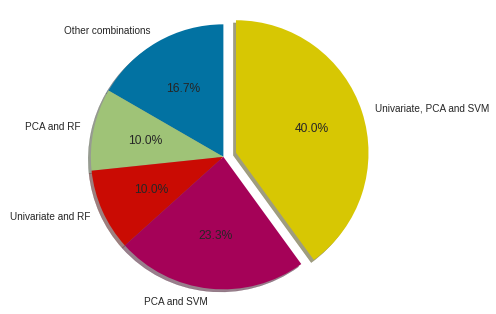

In [34]:
labels = ['Other combinations', 'PCA and RF', 'Univariate and RF', 'PCA and SVM', 'Univariate, PCA and SVM']

sizes = [(count_k_uni + count_k_pca + count_k_uni_pca + count_s_uni + count_r_uni_pca), count_r_pca, count_r_uni, count_s_pca, count_s_uni_pca]
fig1, ax1 = plt.subplots()
explode = (0, 0, 0, 0, 0.1)
ax1.pie(sizes, explode = explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()